In [ ]:
# !unzip "/content/drive/MyDrive/archive.zip" -d "/content/brain tumor/"

In [1]:
import os
import nibabel as nib
import numpy as np
import glob
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from pathlib import Path

In [ ]:
mask1 = np.load("/content/drive/MyDrive/feature_2.npy")
# mask2 = np.load("/content/drive/MyDrive/mask2.npy")
id_mask = np.load("/content/drive/MyDrive/id_2.npy")

In [ ]:
# torch.set_default_dtype(torch.float16)

In [ ]:
id_mask

array(['00588', '00203', '00641', ..., '01206', '00642', '00680'],
      dtype='<U5')

In [ ]:
# def load_mask(id):
#   # mask2=np.zeros((993, 8, 8, 3))
#   maskid = np.where(Feature_Id==id)[0][0]
#   mask = Features[maskid]
#   # mask2 = np.concatenate((mask2, np.moveaxis(mask, -1, 0)), axis = -1)
#   # return mask2
#   return np.moveaxis(mask, -1, 0)

def load_mask(id):
  maskid = np.where(id_mask==id)[0][0]
  # m1 = mask1[maskid]
  # m2 = mask2[maskid]
  mask2 = np.moveaxis(mask1[maskid], -1, 0)
  return mask2
  # return np.moveaxis(m1, -1, 0), np.moveaxis(m2, -1, 0)

In [ ]:
a=load_mask('00588')

(-0.5, 7.5, 7.5, -0.5)

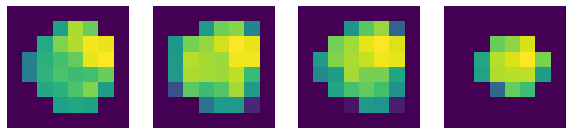

In [ ]:
# mm1 = np.float32(load_mask("00582")[0])
# mm2 = np.float32(load_mask("00582")[1])

# mm1.shape
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(a[0][:,:,1])
ax.axis('off')
ax1 = fig.add_subplot(1, 4, 2)
ax1.imshow(a[0][:,:,2])
ax1.axis('off')
ax2 = fig.add_subplot(1, 4, 3)
ax2.imshow(a[0][:,:,3])
ax2.axis('off')
ax3 = fig.add_subplot(1, 4, 4)
ax3.imshow(a[0][:,:,4])
ax3.axis('off')

In [ ]:
# def load_voxel(study_id, scan_type="FLAIR", split="train", sz=128):
#     assert sz in (64, 128, 256)
#     data_root = Path("/content/brain tumor")
#     npy_path = Path(data_root).joinpath("voxel", split, study_id, f"{scan_type}.npy")
#     voxel = np.load(str(npy_path))
#     return voxel


In [ ]:
# def load_3d_image_alltypes(id, split="train"):
    
#     # flair
    
#     flair=load_voxel(id,"FLAIR",split)
#     t1w=load_voxel(id,"T1w",split)
#     t1wce=load_voxel(id,"T1wCE",split)
#     t2w=load_voxel(id,"T2w",split)
    
#     # data=np.array((flair, t1w, t1wce, t2w))
#     data=np.expand_dims(flair,0)
    
#     # rotate = np.random.randint(0,4)
#     # for i in range(4):
#     #     for j in range(128):
#     #         if rotate:
#     #             rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
#     #             data[i][j] = cv2.rotate(data[i][j], rot_choices[rotate])
            
#     return data

In [ ]:
# b=load_mask('00000')
# b.shape

(993, 8, 8, 5)

In [ ]:
# b=load_3d_image_alltypes('00000')
# b.shape

In [ ]:

class Data(Dataset):
  def __init__(self, split="train", validation_split = 0.75):
    train_df=pd.read_csv("/content/drive/MyDrive/train_labels.csv")
    self.labels={}
    self.ids=[]
    self.split=split
    id=list(train_df["BraTS21ID"])
    value=list(train_df["MGMT_value"])
    for i, j in zip(id, value):
      self.labels[str(i).zfill(5)]=j

    idlist = id_mask.copy()

    fileids=[str(int(i)).zfill(5) for i in idlist]
    for i in id:
        if str(i).zfill(5) in fileids:
            self.ids.append(str(i).zfill(5))
    
    if split=="train":
      self.split=split
      self.ids=self.ids[:int(len(self.ids)*validation_split)]
      # self.ids.remove('00109')
      # self.ids.remove('00123')
    elif split=="valid":
      self.split=split
      self.ids=self.ids[int(len(self.ids)*validation_split):]
      # self.ids.remove('00709')

  def __len__(self):
    return len(self.ids)
      
  def __getitem__(self,index):
    features=load_mask(self.ids[index])
    # images=load_3d_image_alltypes(self.ids[index])
    # mask_1, mask_2=load_mask(self.ids[index])

    if self.split=="test":
      return torch.tensor(image, dtype=torch.float32), self.ids[index]
    else:
      label = self.labels[self.ids[index]]
      # return torch.tensor(mask_1, dtype = torch.float16), torch.tensor(mask_2, dtype = torch.float16), torch.tensor(label, dtype = torch.long)
      # return torch.tensor(features, dtype = torch.float32), torch.tensor(images, dtype = torch.float32), torch.tensor(label, dtype = torch.long)
      return torch.tensor(features, dtype = torch.float32), torch.tensor(label, dtype = torch.long)

In [ ]:
a=Data(split="train")
len(a.ids)

432

In [ ]:
train_dataset = Data(split="train")
train_bs = 8 
train_loader = DataLoader(train_dataset, batch_size = train_bs, shuffle=True)

val_dataset = Data(split="valid")
val_bs = 8
val_loader = DataLoader(val_dataset, batch_size = val_bs, shuffle=True)

In [ ]:
for image1, idx in train_loader:
  # print(feature.shape)
  print(image1.shape)
  print(idx)
  break

torch.Size([8, 993, 8, 8, 5])
tensor([1, 0, 0, 1, 0, 1, 1, 1])


In [ ]:
# class Model(nn.Module):
#   def __init__(self):
#     super(Model, self).__init__() 

#     self.branch2_1 = nn.Conv3d(4,8,kernel_size=5,padding=0)
#     self.branch2_2 = nn.MaxPool3d(kernel_size=2,stride=2)
#     self.branch2_3 = nn.Conv3d(8,8,kernel_size=3,padding=0)
#     self.branch2_4 = nn.MaxPool3d(kernel_size=2,stride=2)
#     self.branch2_5 = nn.Conv3d(8,16,kernel_size=3,padding=0)
#     self.branch2_6 = nn.MaxPool3d(kernel_size=2,stride=2)
#     self.branch2_7 = nn.Conv3d(16,32,kernel_size=3,padding=0)
#     self.branch2_8 = nn.MaxPool3d(kernel_size=2,stride=2)

#     self.branch3_1 = nn.Conv3d(4,8,kernel_size=5,padding=0)
#     self.branch3_2 = nn.MaxPool3d(kernel_size=2,stride=2)
#     self.branch3_3 = nn.Conv3d(8,8,kernel_size=3,padding=0)
#     self.branch3_4 = nn.MaxPool3d(kernel_size=2,stride=2)
#     self.branch3_5 = nn.Conv3d(8,16,kernel_size=3,padding=0)
#     self.branch3_6 = nn.MaxPool3d(kernel_size=2,stride=2)
#     self.branch3_7 = nn.Conv3d(16,32,kernel_size=3,padding=0)
#     self.branch3_8 = nn.MaxPool3d(kernel_size=2,stride=2)
    
#     self.branchflaten = nn.Flatten()
    
#     self.branchfcl_1 = nn.Linear(64*6*6*3,1024)
#     self.branchfcl_2 = nn.Linear(1024,2)

#   def forward(self,input1,input2):
#     # b1=self.branch1(input1)

#     b1=self.branch2_1(input1)
#     b1=torch.relu(b1)
#     b1=self.branch2_2(b1)
#     b1=self.branch2_3(b1)
#     b1=torch.relu(b1)
#     b1=self.branch2_4(b1)
#     b1=self.branch2_5(b1)
#     b1=torch.relu(b1)
#     b1=self.branch2_6(b1)
#     b1=self.branch2_7(b1)
#     b1=torch.relu(b1)
#     b1=self.branch2_8(b1)

#     b2=self.branch3_1(input2)
#     b2=torch.relu(b2)
#     b2=self.branch3_2(b2)
#     b2=self.branch3_3(b2)
#     b2=torch.relu(b2)
#     b2=self.branch3_4(b2)
#     b2=self.branch3_5(b2)
#     b2=torch.relu(b2)
#     b2=self.branch3_6(b2)
#     b2=self.branch3_7(b2)
#     b2=torch.relu(b2)
#     b2=self.branch3_8(b2)


#     fcn = torch.cat((b1,b2),1)
    
#     fcn = self.branchflaten(fcn)
#     out = self.branchfcl_1(fcn)
#     out=torch.relu(out)
#     out = self.branchfcl_2(out)
    
#     return out


# model=Model()

In [ ]:
for image1, image2, idx in train_loader:
  image1 = torch.tensor(image1).to(gpu)
  image2 = torch.tensor(image2).to(gpu)
  idx = torch.tensor(idx).to(gpu)

  output = model(image1,image2)
  print(output)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr = 0.001, weight_decay=0.08)
n_epochs = 15

def one_hot(arr):
  return [[1, 0] if a_i == 0 else [0, 1] for a_i in arr]



In [ ]:
model = nn.Sequential(
    nn.Conv3d(993,256, kernel_size=3, padding=0),
    nn.ReLU(),
    nn.MaxPool3d(kernel_size=3, stride=1),
    
    nn.Flatten(),
    nn.Linear(256*4*4*1,1024),
    nn.ReLU(),
    nn.Linear(1024,2)
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr = 0.00001, weight_decay=0.08)
n_epochs = 100

def one_hot(arr):
  return [[1, 0] if a_i == 0 else [0, 1] for a_i in arr]


def auc(a,b):
  c=[1 if x[1] > 0.5 else 0 for x in b]
  count=0
  for i in range(len(a)):
    if a[i]==c[i]:
      count+=1
  return count/len(a)


In [ ]:
# class Model(nn.Module):
#   def __init__(self):
#     super(Model, self).__init__() 
#     # self.branch1 = BasicConv2d(993,256,kernel_size=3,padding=0) # 441

#     self.branch2_1 = nn.Conv3d(1,4,kernel_size=3,padding=0)
#     self.branch2_3 = nn.MaxPool3d(kernel_size=2,stride=2)
#     self.branch2_2 = nn.Conv3d(4,4,kernel_size=5,padding=0)
#     self.branch2_4 = nn.MaxPool3d(kernel_size=2,stride=2)

#     self.branch3_1 = nn.Conv3d(1,4,kernel_size=3,padding=0)
#     self.branch3_3 = nn.MaxPool3d(kernel_size=2,stride=2)
#     self.branch3_2 = nn.Conv3d(4,4,kernel_size=5,padding=0)
#     self.branch3_4 = nn.MaxPool3d(kernel_size=2,stride=2)

#     self.branch4_1 = nn.Conv3d(1,4,kernel_size=3,padding=0)
#     self.branch4_3 = nn.MaxPool3d(kernel_size=2,stride=2)
#     self.branch4_2 = nn.Conv3d(4,4,kernel_size=5,padding=0)
#     self.branch4_4 = nn.MaxPool3d(kernel_size=2,stride=2)
    
#     self.branchflaten = nn.Flatten()
    
#     self.branchfcl_1 = nn.Linear(12*29*29*17,1024)
#     self.branchfcl_2 = nn.Linear(1024,2)

#   def forward(self,input2,input3,input4):
#     # b1=self.branch1(input1)

#     b2=self.branch2_1(input2)
#     b2=torch.relu(b2)
#     b2=self.branch2_3(b2)
#     b2=self.branch2_2(b2)
#     b2=torch.relu(b2)
#     b2=self.branch2_4(b2)

#     b3=self.branch3_1(input3)
#     b3=torch.relu(b3)
#     b3=self.branch3_3(b3)
#     b3=self.branch3_2(b3)
#     b3=torch.relu(b3)
#     b3=self.branch3_4(b3)

#     b4=self.branch4_1(input4)
#     b4=torch.relu(b4)
#     b4=self.branch4_3(b4)
#     b4=self.branch4_2(b4)
#     b4=torch.relu(b4)
#     b4=self.branch4_4(b4)

#     fcn = torch.cat((torch.cat((b2,b3),1),b4),1)
    
#     fcn = self.branchflaten(fcn)
#     out = self.branchfcl_1(fcn)
#     out=torch.relu(out)
#     out = self.branchfcl_2(out)
    
#     return out


# model=Model()

In [ ]:

# class Block(nn.Module):
#   def __init__(self, in_c, out_c, drop_rate=0.0):
#       super(Block, self).__init__()

#       layers = [nn.Conv3d(in_c, out_c, 3, 1, 1),
#                 nn.ReLU(),
#                 nn.MaxPool3d(2,stride=2),
#                 nn.BatchNorm3d(out_c)]

#       if drop_rate > 0:
#           layers += [nn.Dropout(drop_rate)]

#       self.features = nn.Sequential(*layers)

#   def forward(self, x):
#       return self.features(x)

# class new_model(nn.Module):
#   def __init__(self, num_classes=2, n_init_features=1):
#     super(new_model, self).__init__()
#     self.conv1 = Block(n_init_features, 32)
#     self.conv2 = Block(32, 64,drop_rate=0.02)
#     self.conv3 = Block(64, 128,drop_rate=0.04)
#     self.conv4 = Block(128, 256,drop_rate=0.08)
#     self.conv_fea = nn.Conv3d(993, 512, 3, 1, 1)
#     self.avg = nn.AdaptiveAvgPool3d(1)
#     self.fc1 = nn.Linear(768, 1024)
#     self.drop = nn.Dropout(0.08)
#     self.relu1 = nn.ReLU()
#     self.fc2 = nn.Linear(1024, num_classes)
#     self.fla = nn.Flatten()


#   def forward(self,x,feature_y):
#     x1 = self.conv1(x)
#     # x_cat1 = torch.cat((x1,x),2)
#     x2 = self.conv2(x1)
#     # x_cat2 = torch.cat((x2,x1),2)
#     x3 = self.conv3(x2)
#     # x_cat3 = torch.cat((x3,x2),2)
#     x4 = self.conv4(x3)
#     # x_cat4 = torch.cat((x4,x3),2)

#     x_feature = self.conv_fea(feature_y)
#     x_feature = self.relu1(x_feature)# channel 993 to 512

#     x5 = torch.cat((x4,x_feature),1) # 512+256 = 768
#     x6 = self.avg(x5)
#     x7 = self.fla(x6)
#     x8 = self.fc1(x7)
#     x9 = self.drop(x8)
#     x10 = self.relu1(x9)
#     x11 = self.fc2(x10)
#     return x11

# model = new_model()

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.AdamW(model.parameters(),lr = 0.0001, weight_decay=0.08)
# n_epochs = 50

# def one_hot(arr):
#   return [[1, 0] if a_i == 0 else [0, 1] for a_i in arr]
  

In [ ]:
gpu = torch.device(f"cuda:0")
model.to(gpu)

Sequential(
  (0): Conv3d(993, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (1): ReLU()
  (2): MaxPool3d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=4096, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=2, bias=True)
)

In [ ]:
# for image1, image2, idx in train_loader:
#   image1 = torch.tensor(image1).to(gpu)
#   image2 = torch.tensor(image2).to(gpu)
#   idx = torch.tensor(idx).to(gpu)

#   output = model(image1,image2)
#   print(output)

#   break

In [ ]:
train_loss = []
val_loss = []
train_roc = []
train_acc = []
val_roc = []
val_acc = []
best_roc = 0.0

for epoch in range(n_epochs):  # loop over the dataset multiple times
#     scheduler.step()
    
    y_all = []
    outputs_all = []
    output_all = []
    running_loss = 0.0
    roc = 0.0
    n=0
    
    model.train()
    for i, data in enumerate(train_loader, 0):
        x, y = data
        
        # feature = feature.to(gpu)
        x = x.to(gpu)
        y = y.to(gpu)

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n+=1
        y_all.extend(y.tolist())
        outputs_all.extend(outputs.tolist())
        output_all.extend(torch.softmax(outputs,dim=1).tolist())

    roc = roc_auc_score(one_hot(y_all), outputs_all)
    y_all = [1 if x > 0.5 else 0 for x in y_all]
    acc = auc(y_all, output_all)
    print(f"epoch {epoch+1} train loss: {running_loss/n} train auc: {roc} train acc: {acc}")
    
    train_loss.append(running_loss/n)
    train_roc.append(roc)
    train_acc.append(acc)

    y_all = []
    outputs_all = []
    output_all = []
    running_loss = 0.0
    roc = 0.0 
    n=0
    

    for i, data in enumerate(val_loader, 0):

        x, y = data
        
        # feature = feature.to(gpu)
        x = x.to(gpu)
        y = y.to(gpu)
        

        outputs = model(x)
        loss = criterion(outputs, y)

        running_loss += loss.item()
        n+=1
        y_all.extend(y.tolist())
        outputs_all.extend(outputs.tolist())
        output_all.extend(torch.softmax(outputs,dim=1).tolist())
    
    
    roc = roc_auc_score(one_hot(y_all), outputs_all)
    y_all = [1 if x > 0.5 else 0 for x in y_all]
    acc = auc(y_all, output_all)
#     scheduler.step(running_loss)
        
    print(f"epoch {epoch+1} val loss: {running_loss/n} val auc: {roc} val acc: {acc}")
    
    val_loss.append(running_loss/n)
    val_roc.append(roc)
    val_acc.append(acc)
    
    # if roc > best_roc:
    #     best_roc = roc
    #     torch.save(model.state_dict(), f'best_roc_{round(roc, 2)}_loss_{round(running_loss, 2)}.pt')

In [ ]:
# record=pd.DataFrame(columns=['train_loss','valid_loss','train_acc','train_auc','valid_acc','valid_auc'])
# record['train_loss']=train_loss
# record['valid_loss']=val_loss
# record['train_acc']=train_acc
# record['train_auc']=train_roc

# record['valid_acc']=val_acc
# record['valid_auc']=val_roc

# record.to_csv('1.csv')

result=pd.read_csv("/content/drive/MyDrive/seg_1_training.log")

result.head()

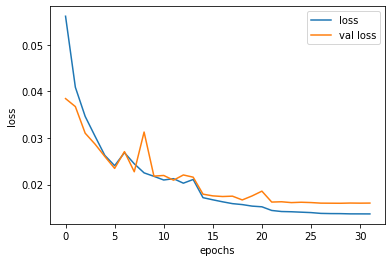

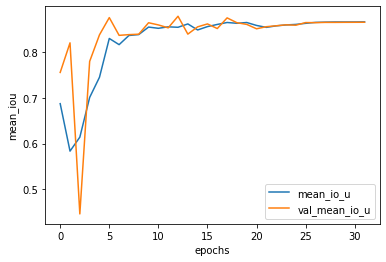

In [ ]:
plt.plot(result['loss'], label = 'loss')
plt.plot(result['val_loss'], label = 'val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val loss'])
plt.show()

plt.plot(result['mean_io_u'], label = 'mean_io_u')
plt.plot(result['val_mean_io_u'], label = 'val_mean_io_u')
plt.xlabel('epochs')
plt.ylabel('mean_iou')
plt.legend(['mean_io_u', 'val_mean_io_u'])
plt.show()

In [4]:
# import seaborn as sn

result=pd.read_csv("/content/drive/MyDrive/result/middle feature.csv")

result['valid_auc'].max()

0.6378915202444615